# Generative deep learning
In this notebook we build a simple generative model. This model will help us to understand
the basic functionalty of generative deep learning models. 

## Libraries
Again we use [Keras](https://keras.io/) to build the model. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, callbacks, saving

import tensorflow.keras.backend as K

## Parameters and helpers. 
The following cell defines a few parameters used later in the notebook. In addition, the helper function `display` is defined. It can be used do select and display 10 random imaged for the dataset. 

In [12]:
import random

IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

def display(images, n=10):
    """
    Displays n random images from the supplied array.
    """
    if images.max() > 1.0:
        images = images / 255.0
    
    plt.figure()
    if len(images) > n:
        indices = random.sample(range(len(images)),k=n)
    else: 
        indices = range(len(images))
        
    for i, j in enumerate(indices):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[j],cmap="gray_r")
        plt.axis("off")

plt.show()

# Autoencoder  
The model we build in this notebook is a [autoencoder](https://en.wikipedia.org/wiki/Autoencoder). 
## 1. Prepare the data
Again, the first step is to load and prepare the data. This time we use 
the [fashion MNIST](https://keras.io/api/datasets/fashion_mnist/)
dataset. The dataset consists of 70.000 28x28 grayscale images of clothing items. 

In [13]:
(x_train,y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()
np.shape(x_train)

(60000, 28, 28)

Again the values are converted form `int` in the range 0 - 255 into floats in the range 0 - 1. 
In addition the images are padded to size 32 * 32 to simplyfy manipulation in subsequent steps.

In [14]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0) 
    imgs = np.expand_dims(imgs, -1)
    return imgs
    
x_train = preprocess(x_train)
x_test = preprocess(x_test)
np.shape(x_train)

(60000, 32, 32, 1)

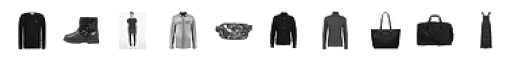

In [15]:
display(x_train)

## 2. Build the autoencoder 
The architecture of an autoencoder consist of two parts:
1. An **encoder** network that compresses high-dimensional input data into an lower-dimensional latent space.
2. A **decoder** network that decompresses a given value from the latent space back to the original high-dimensional input space.
 
### 2.1. Encode
First, we create the encoder network. In this example the encoder compresses the input data into a two dimensional 
latent space. This will allow us to visualize the latent space afterwards. 

In [16]:
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Decoder
The decoder reverses the process of the encoder. Starting from a two dimensional latent space
a 32 * 32 image is created. 

In [17]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

## 2.3 Autoencoder
Finally, we create the autoencoder by joining the encoder and the decoder.

In [19]:
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  
autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Training the autoencoder
Next, the model is trained.

In [20]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
)


Epoch 1/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - loss: 0.3684 - val_loss: 0.2600
Epoch 2/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - loss: 0.2587 - val_loss: 0.2570
Epoch 3/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - loss: 0.2542 - val_loss: 0.2544


## 4. Reconstruction using the autoencoder
Once the autoencoder is trained we can use it to encode and reconstruct images. Note, 
that the reconstructed imaged lose some of the details (like e.g. logos) of the original 
images.

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Example real clothing items
Reconstructions


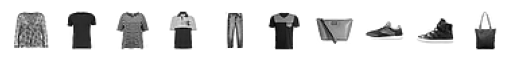

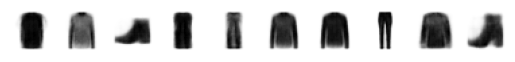

In [22]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

## 5. Examining the latent space
In the next step we visualize the latent space to see how the autoencoder compressed the training data.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[ 3.0991428  -0.05728892]
 [ 1.4399654   7.6278224 ]
 [-7.5318775   4.1904845 ]
 [-4.7231836   2.1787949 ]
 [ 1.1880566   4.148687  ]
 [-4.865945    4.010223  ]
 [-0.222839    2.8776686 ]
 [ 0.4812654   3.658962  ]
 [ 2.377273   -2.3445866 ]
 [ 4.423345   -2.3365724 ]]


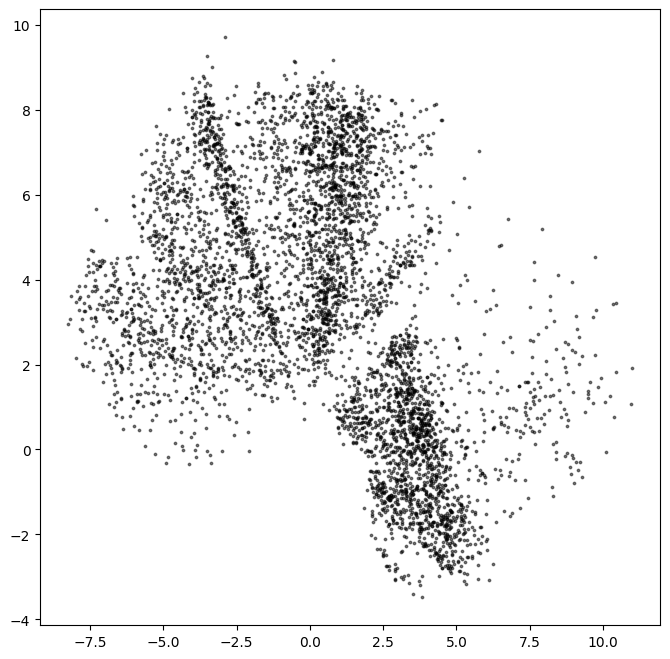

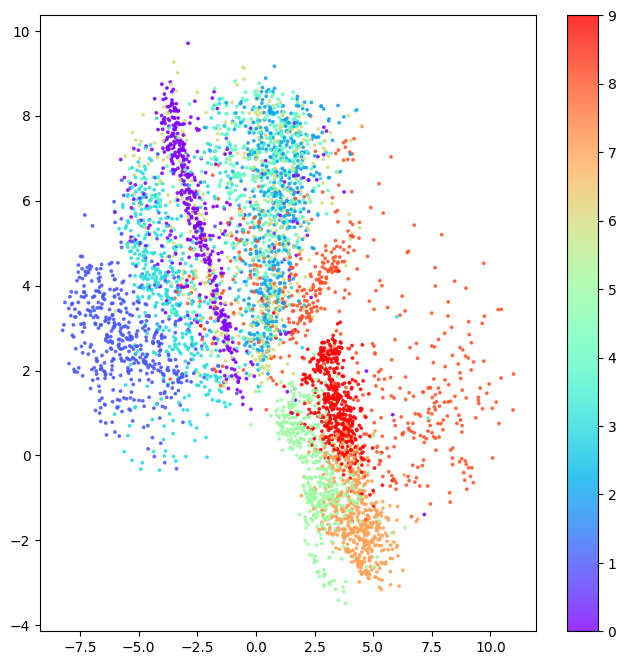

In [24]:
# Encode the example images
embeddings = encoder.predict(example_images)

# Some examples of the embeddings
print(embeddings[:10])

# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## 6. Generate images using the decoder

In [25]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)


In [26]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


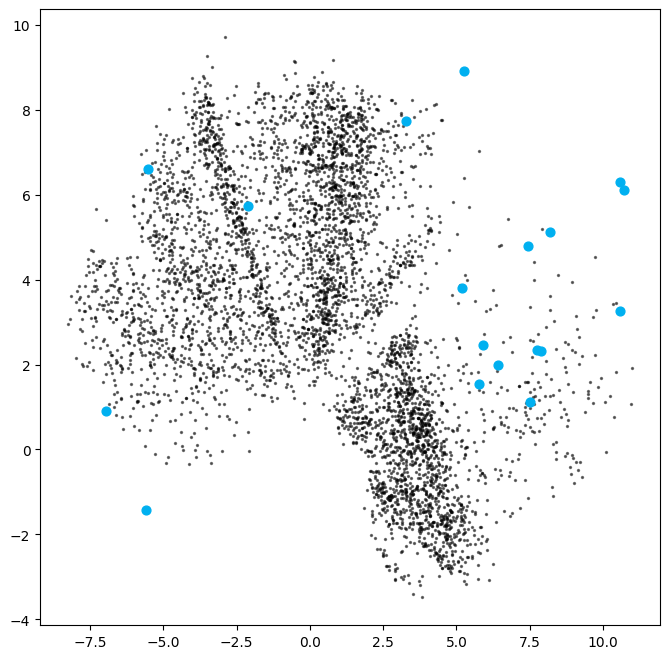

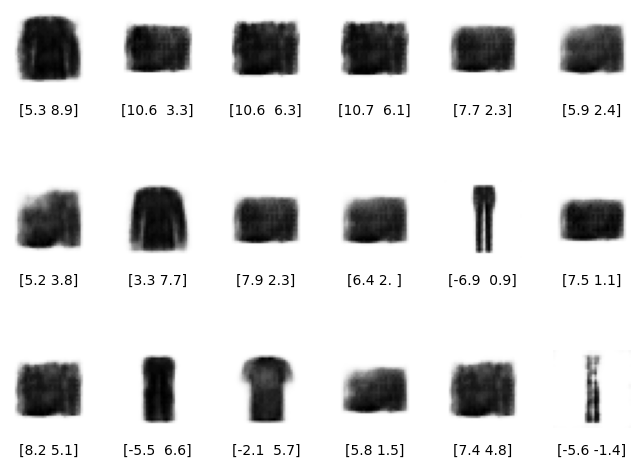

In [27]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [28]:
grid_size = 5
x = np.linspace(mins[0], maxs[0], num=grid_size)
y = np.linspace(mins[1], maxs[1], num=grid_size)
grid = np.meshgrid(x, y)
sample = np.dstack(grid).reshape((-1, 2))
np.shape(sample)

(25, 2)

In [30]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


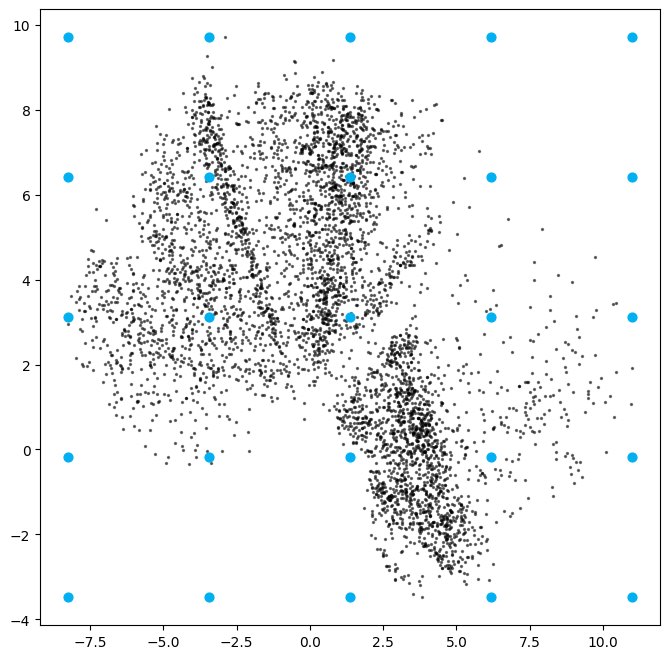

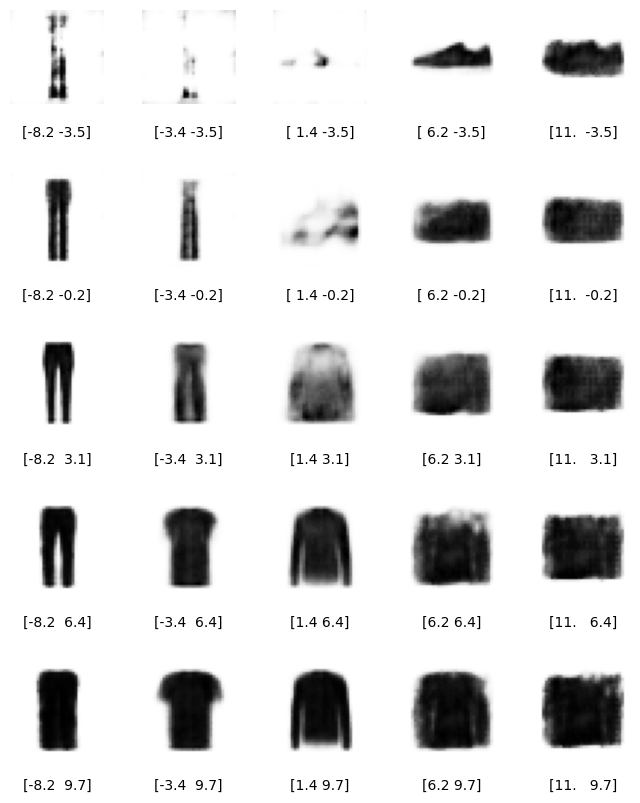

In [31]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_size * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size ** 2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")